In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import csr_matrix

In [48]:
# Load the datasets

In [49]:
movies = pd.read_csv('../data/raw/movie.csv')
ratings = pd.read_csv('../data/raw/rating.csv')
tags = pd.read_csv('../data/raw/tag.csv')
links = pd.read_csv('../data/raw/link.csv')

In [50]:
movies.head()
ratings.head()
tags.head()
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [51]:
# movies.csv: Movie metadata (movieId, title, genres)
# ratings.csv: User ratings (userId, movieId, rating, timestamp)
# tags.csv: User-generated tags for movies
# links.csv: External identifiers (IMDb IDs)

In [52]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [53]:
ratings.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


In [54]:
# Unique counts
print(f"Number of unique users: {ratings['userId'].nunique()}")
print(f"Number of unique movies: {movies['movieId'].nunique()}")

Number of unique users: 138493
Number of unique movies: 27278


In [55]:
# Ensure columns are numeric
ratings['userId'] = pd.to_numeric(ratings['userId'], errors='coerce')
ratings['movieId'] = pd.to_numeric(ratings['movieId'], errors='coerce')
ratings['rating'] = pd.to_numeric(ratings['rating'], errors='coerce')

C:\Users\jmalo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


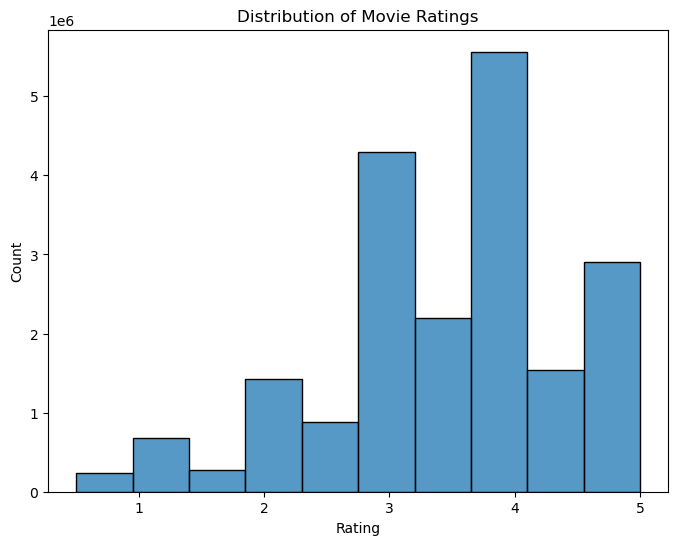

In [56]:
# Plot distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(ratings['rating'], bins=10)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [57]:
# Find most popular movies

In [58]:
# Count of ratings per movie
movie_ratings_count = ratings.groupby('movieId')['rating'].count().reset_index()
movie_ratings_count.columns = ['movieId', 'rating_count']

In [59]:
# Merge with movie titles
popular_movies = movie_ratings_count.merge(movies, on='movieId')
popular_movies = popular_movies.sort_values(by='rating_count', ascending=False)

In [60]:
# Display top 10 rated movies
popular_movies.head(10)

,movieId,rating_count,title,genres
293,296,67310,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
352,356,66172,Forrest Gump (1994),Comedy|Drama|Romance|War
315,318,63366,"Shawshank Redemption, The (1994)",Crime|Drama
587,593,63299,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
476,480,59715,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
257,260,54502,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
108,110,53769,Braveheart (1995),Action|Drama|War
583,589,52244,Terminator 2: Judgment Day (1991),Action|Sci-Fi
2486,2571,51334,"Matrix, The (1999)",Action|Sci-Fi|Thriller
523,527,50054,Schindler's List (1993),Drama|War


In [61]:
# Check for missing values
movies.isnull().sum()
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [62]:
# Convert timestamps
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])
ratings['date'] = pd.to_datetime(ratings['timestamp']).dt.date
ratings['time'] = pd.to_datetime(ratings['timestamp']).dt.time
ratings['year'] = ratings['timestamp'].dt.year
ratings = ratings.drop('timestamp', axis=1)
ratings.head()

,userId,movieId,rating,date,time,year
0,1,2,3.5,2005-04-02,23:53:47,2005
1,1,29,3.5,2005-04-02,23:31:16,2005
2,1,32,3.5,2005-04-02,23:33:39,2005
3,1,47,3.5,2005-04-02,23:32:07,2005
4,1,50,3.5,2005-04-02,23:29:40,2005


In [63]:
# Check for duplicate ratings
duplicate_ratings = ratings[ratings.duplicated(subset=['userId', 'movieId'], keep=False)]
print(duplicate_ratings)

Empty DataFrame
Columns: [userId, movieId, rating, date, time, year]
Index: []


In [64]:
ratings['userId'].shape
ratings['movieId'].shape

(20000263,)

In [65]:
# Check for negative userId or movieId
invalid_user_ids = ratings[ratings['userId'] < 0]
invalid_movie_ids = movies[movies['movieId'] < 0]

print(f"Invalid userIds: {invalid_user_ids.shape[0]}")
print(f"Invalid movieIds: {invalid_movie_ids.shape[0]}")

Invalid userIds: 0
Invalid movieIds: 0


In [66]:
# Ensure columns are numeric
ratings['userId'] = pd.to_numeric(ratings['userId'], errors='coerce')
ratings['movieId'] = pd.to_numeric(ratings['movieId'], errors='coerce')
ratings['rating'] = pd.to_numeric(ratings['rating'], errors='coerce')

# Remove rows with invalid userId, movieId, or rating
ratings = ratings.dropna(subset=['userId', 'movieId', 'rating'])

In [67]:
# New column with movie release year
movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False) # regex 4 digits in parenthesis
movies['release_year'] = pd.to_numeric(movies['release_year'])
# Type cast to int
print(movies['release_year'].isna().sum())
movies['release_year'] = movies['release_year'].fillna(0)
movies['release_year'] = movies['release_year'].astype(int)
movies.head()

22


,movieId,title,genres,release_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [68]:
# Merge datasets
merged_data = pd.merge(ratings, movies, on='movieId')
merged_data.head()

,userId,movieId,rating,date,time,year,title,genres,release_year
0,1,2,3.5,2005-04-02,23:53:47,2005,Jumanji (1995),Adventure|Children|Fantasy,1995
1,5,2,3.0,1996-12-25,15:26:09,1996,Jumanji (1995),Adventure|Children|Fantasy,1995
2,13,2,3.0,1996-11-27,08:19:02,1996,Jumanji (1995),Adventure|Children|Fantasy,1995
3,29,2,3.0,1996-06-23,20:36:14,1996,Jumanji (1995),Adventure|Children|Fantasy,1995
4,34,2,3.0,1996-10-28,13:29:44,1996,Jumanji (1995),Adventure|Children|Fantasy,1995


In [69]:
# Filtering out movies with low rating data

In [88]:
# Movie popularity
movies['rating_count'] = ratings.groupby('movieId')['rating'].transform('count')
movies['rating_count'].sort_values(ascending=True).head()
# User activity
ratings['user_rating_count'] = ratings.groupby('userId')['rating'].transform('count')
ratings['user_rating_count'].sort_values(ascending=True).head()

17042316    20
3730529     20
3730528     20
3730527     20
3730526     20
Name: user_rating_count, dtype: int64

In [71]:
# Findings: There are many movies with minimal rating data that we should remove.  All users have rated 20 or more films which is a good minimum.

In [87]:
movies.loc[movies['rating_count'] < 50].count()

movieId         92
title           92
genres          92
release_year    92
rating_count    92
dtype: int64

In [85]:
# Remove movies with less than 50 ratings
ratings_count = merged_data['movieId'].value_counts()
merged_data = merged_data[merged_data['movieId'].isin(ratings_count[ratings_count > 50].index)]

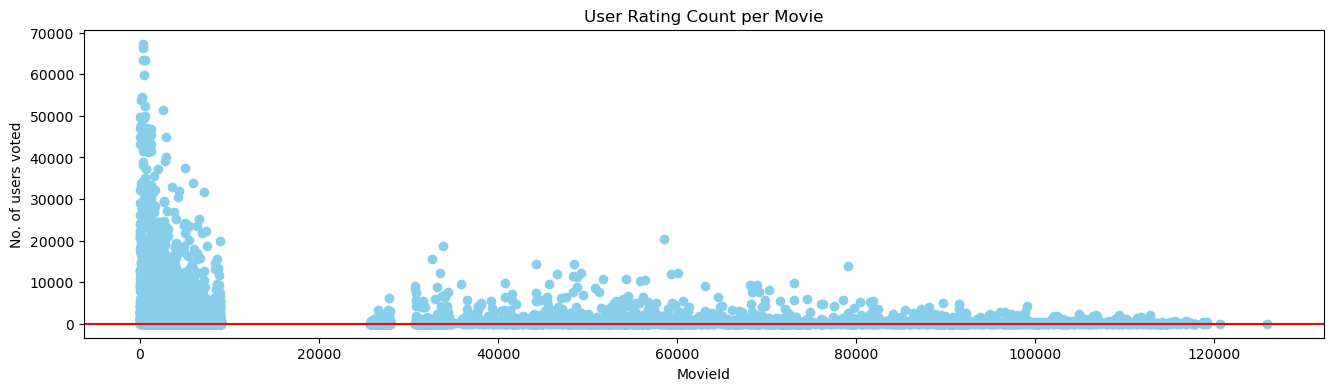

In [90]:
num_users_voted = merged_data.groupby('movieId')['rating'].agg('count')
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)

plt.scatter(num_users_voted.index, num_users_voted, color='skyblue')
plt.axhline(y=10,color='r')
plt.title("User Rating Count per Movie")
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [74]:
# Pivot table to be used for user-item interaction matrix - each row corresponds to a user and each column to a movie

In [75]:
user_movie_matrix = merged_data.pivot(index='userId', columns='movieId', values='rating')
user_movie_matrix = user_movie_matrix.fillna(0)

In [76]:
user_movie_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,118700,118702,118900,118985,118997,119141,119145,119155,120635,125916
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Exploratory Data Analysis

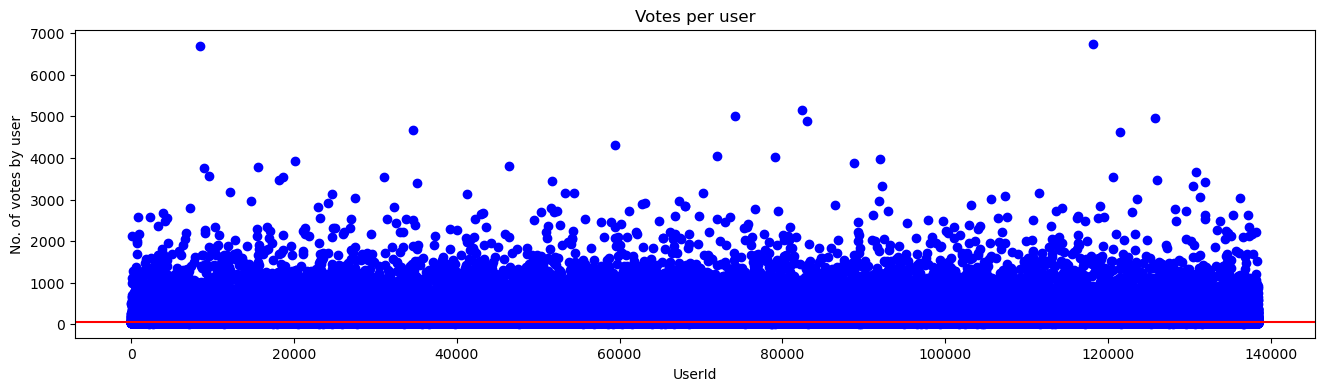

In [89]:
num_movies_voted = merged_data.groupby('userId')['rating'].agg('count')
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(num_movies_voted.index,num_movies_voted,color='blue')
plt.axhline(y=50,color='r')
plt.title("Votes per user")
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [79]:
# Find movie rating avg

In [80]:
# ratings based on genre

In [81]:
# Users that liked a specific genre